<a href="https://colab.research.google.com/github/vshalisko/GEE/blob/main/Colab/Landsat_ANN_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Uso de ANN para clasificacion de Landsat

In [1]:
!pip install pyrsgis

Preparar el entorno

In [2]:
import ee
import geemap
import random
import math, glob, time
import numpy as np
from pyrsgis import raster, convert
import matplotlib.pyplot as plt
from google.colab import drive

random.seed(2)

Conección con GEE

In [3]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-viacheslavs')

Coneccion con Google Drive para almacenar archivos

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


Lectura de capas de datos

In [6]:
punto_interes = ee.Geometry.Point([-103.76, 19.75])
fecha_inicio = '2015-02-01'
fecha_final = '2015-05-30'

print(punto_interes.getInfo())

# filtrado de datos Landsat potencialemtne adecuados
L8_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").filterBounds(punto_interes).filterDate(fecha_inicio, fecha_final).filter(ee.Filter.lessThan('CLOUD_COVER', 1))
print('Capas de datos filtrados:', L8_collection.size().getInfo())

# Cargar imagen de la colección (Landsat 8).
L8_image = L8_collection.first()

# Load builtup 2015 (res 100 m)
ghs_built_image = ee.Image('JRC/GHSL/P2023A/GHS_BUILT_S/2015')
built_2015_lr = ghs_built_image.select('built_surface')

# Load builtup 2015 (res 10 m)
built_2015_hr = ee.Image('DLR/WSF/WSF2015/v1')

# blackBackground = ee.Image(0);


{'type': 'Point', 'coordinates': [-103.76, 19.75]}
Capas de datos filtrados: 2


Visualizar capas de datos

In [7]:

Map = geemap.Map()
# Center the map and display the image.
Map.centerObject(punto_interes, 8)

# Parametros de visualizacion para Landsat 8
vizParams_L8 = {
  'bands': ['SR_B5', 'SR_B4', 'SR_B3'],
   'min': 5000,
   'max': 15000
  #'gamma': [0.95, 1.1, 1]
}
# Parametros de visualizacion para Builtup LR
vizBuiltup_LR = {
   'min': 0,
   'max': 1,
  'palette': ['white','black']
}
# Parametros de visualizacion para Builtup HR
vizBuiltup_HR = {
  min: 0,
  max: 255,
  'palette': ['white','black']
}

# Agregar capas
Map.addLayer(L8_image, vizParams_L8, 'Composición de falso color', True, 0.5)
Map.addLayer(built_2015_lr, vizBuiltup_LR, 'Builtup 2015 100m', True, 0.5)
Map.addLayer(built_2015_hr, vizBuiltup_HR, 'Builtup 2015 10m', True, 0.5)

# Presentar mapa
Map


Map(center=[19.75, -103.76], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

Conversión de datos en numpy array para el analisis

In [8]:
image_meta = L8_image.getInfo()
imagename = image_meta.get('properties',{}).get('LANDSAT_PRODUCT_ID')
#imagename = image_meta.get('properties',{})
print(imagename)

projection = L8_image.projection().getInfo();
print(projection)
print(projection.get('crs'))

## Reproject label layer
built_2015_hr_reprojected = built_2015_hr.reproject(projection.get('crs'), projection.get('transform'))
#print(built_2015_hr_reprojected.getInfo())

# convert all to UTM in order to get good rectangle
limites_geo = [-103.65,-103.05, 20.43, 20.95]
limites_utm = [640453, 702758, 2260275, 2317848]
pixel = 30
max_tile = 250000
utm13 = ee.Projection('EPSG:32613')


def segmentation(limits, pixel_size, max_tile_size, proj):
  alto = math.ceil((limits[3] - limits[2]) / pixel_size)
  print('Alto del segmento (pixeles)', alto)
  ancho = math.ceil(max_tile_size / alto)
  print('Ancho del segmento (pixeles)', ancho)
  incremento = ancho * pixel_size
  print('Ancho del segmento (unidades de proyeccion)', incremento)
  seq = list(np.arange(limits[0], limits[1], incremento))
  print('Secuencia de marcas de longitud')
  print(seq)
  segments = []
  for i in range(len(seq)-1):
    #print(seq[i], seq[i+1])
    segment = ee.Geometry.Rectangle([int(seq[i]), limites_utm[2], int(seq[i+1]), limites_utm[3]], proj, True, False)
    #print(segment)
    segments.append(segment)
  return segments

segment_list = segmentation(limites_utm, pixel, max_tile, utm13)

Map1 = geemap.Map()
bbox = ee.Geometry.Rectangle([limites_utm[0], limites_utm[2], limites_utm[1], limites_utm[3]], utm13, True, False)
Map1.centerObject(punto_interes, 8)
Map1.addLayer(bbox, {}, 'Area de estudio')
Map1

LC08_L2SP_029046_20150208_20200909_02_T1
{'type': 'Projection', 'crs': 'EPSG:32613', 'transform': [30, 0, 551685, 0, -30, 2352915]}
EPSG:32613
Alto del segmento (pixeles) 1920
Ancho del segmento (pixeles) 131
Ancho del segmento (unidades de proyeccion) 3930
Secuencia de marcas de longitud
[640453, 644383, 648313, 652243, 656173, 660103, 664033, 667963, 671893, 675823, 679753, 683683, 687613, 691543, 695473, 699403]


Map(center=[19.75, -103.76], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [9]:
bands_L8 = ['SR_B2','SR_B3','SR_B4','SR_B5','SR_B6','SR_B7']
bands_B = ['settlement']

def tile_to_numpy(image, rectangle, bands):
  ## extraccion de bandas en un region rectangular
  image_tile = image.sampleRectangle(region=rectangle,defaultValue=0)
  first_band = image_tile.get(bands[0])
  band_array_np = np.array(first_band.getInfo())
  band_array_np = np.expand_dims(band_array_np, 2)
  for b in bands[1:]:
    b_arr = image_tile.get(b)
    b_arr_np = np.array(b_arr.getInfo())
    b_arr_np = np.expand_dims(b_arr_np, 2)
    #print(b_arr_np.shape)
    #print(band_array_np.shape)
    band_array_np = np.concatenate((band_array_np, b_arr_np), 2)
  return band_array_np


In [10]:
# definición de un region pequeño para el analisis (GEO)
aoi0 = ee.Geometry.Polygon(
        [[[-103.42046006557397, 20.721686475573005],
          [-103.42046006557397, 20.694710560279958],
          [-103.39846006557397, 20.694710560279958],
          [-103.39846006557397, 20.721686475573005]]], None, False);
aoi1 = ee.Geometry.Polygon(
        [[[-103.39846006557397, 20.721686475573005],
          [-103.39846006557397, 20.694710560279958],
          [-103.36309782192163, 20.694710560279958],
          [-103.36309782192163, 20.721686475573005]]], None, False);
aoi2 = ee.Geometry.Polygon(
        [[[-103.36309782192163, 20.721686475573005],
          [-103.36309782192163, 20.694710560279958],
          [-103.32773557826929, 20.694710560279958],
          [-103.32773557826929, 20.721686475573005]]], None, False);

Cero feature array (102, 79, 6)
First feature array (102, 124, 6)
Second feature array (102, 125, 6)
Small test feature array (102, 328, 6)


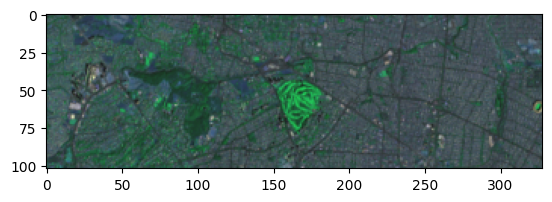

In [11]:
array0 = tile_to_numpy(L8_image, aoi0, bands_L8)
print("Cero feature array", array0.shape)
array1 = tile_to_numpy(L8_image, aoi1, bands_L8)
print("First feature array", array1.shape)
array2 = tile_to_numpy(L8_image, aoi2, bands_L8)
print("Second feature array", array2.shape)

array_small_feature = np.concatenate((array0, array1, array2), 1)
print("Small test feature array", array_small_feature.shape)

# Scale the data to [0, 255] to show as an RGB image.
rgb_img_test = (255*((array_small_feature - 5000)/30000)).astype('uint8')
plt.imshow(rgb_img_test[:,:,2:5])
plt.show()

Cero Label array (102, 79, 1)
Firsy label array (102, 124, 1)
Second label array (102, 125, 1)
Small test label array (102, 328, 1)


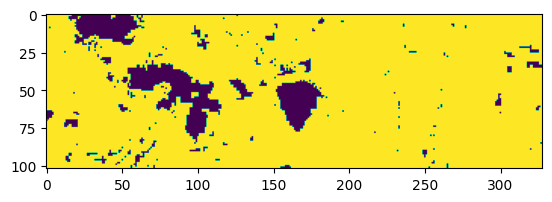

In [12]:
arrayL0 = tile_to_numpy(built_2015_hr_reprojected, aoi0, bands_B)
print("Cero Label array", arrayL0.shape)
arrayL1= tile_to_numpy(built_2015_hr_reprojected, aoi1, bands_B)
print("Firsy label array", arrayL1.shape)
arrayL2 = tile_to_numpy(built_2015_hr_reprojected, aoi2, bands_B)
print("Second label array", arrayL2.shape)

array_small_labels = np.concatenate((arrayL0, arrayL1, arrayL2), 1)
print("Small test label array", array_small_labels.shape)

# Scale the data to [0, 255] to show as an RGB image.
B_img_test = (array_small_labels).astype('uint8')
plt.imshow(B_img_test[:,:,0])
plt.show()

In [13]:
# Save the arrays as .npy files
np.save('/content/drive/MyDrive/Colab Data/array_small_feature.npy', array_small_feature)
np.save('/content/drive/MyDrive/Colab Data/array_small_labels.npy', array_small_labels)

Preparar datos de entrenamiento en zona de estudio

New feature array (1920, 132, 6)
Feature segment (1920, 132, 6)
Feature segment (1920, 132, 6)
Feature segment (1920, 132, 6)
Feature segment (1920, 132, 6)
Feature segment (1920, 132, 6)
Feature segment (1920, 132, 6)
Feature segment (1920, 132, 6)
Feature segment (1920, 132, 6)
Feature segment (1920, 132, 6)
Feature segment (1920, 132, 6)
Feature segment (1920, 132, 6)
Feature segment (1920, 132, 6)
Feature segment (1920, 132, 6)


Feature segment (1920, 132, 6)
Full new feature array (1920, 1980, 6)


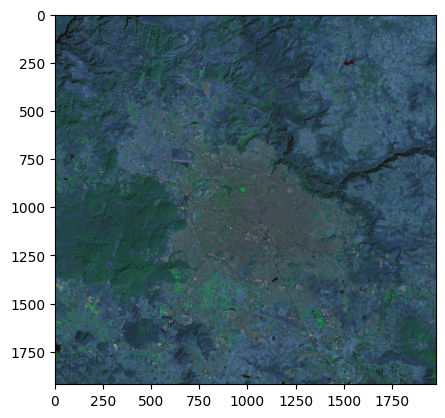

In [14]:
array_feature = tile_to_numpy(L8_image, segment_list[0], bands_L8)
print("New feature array", array_feature.shape)
for segment in segment_list[1:]:
  feature_segment = tile_to_numpy(L8_image, segment, bands_L8)
  print("Feature segment", feature_segment.shape)
  array_feature = np.concatenate((array_feature, feature_segment), 1)
print("Full new feature array", array_feature.shape)

# Scale the data to [0, 255] to show as an RGB image.
rgb_img_new = (255*((array_feature - 5000)/30000)).astype('uint8')
plt.imshow(rgb_img_new[:,:,2:5])
plt.show()

New label array (1920, 132, 1)
Label segment (1920, 132, 1)
Label segment (1920, 132, 1)
Label segment (1920, 132, 1)
Label segment (1920, 132, 1)
Label segment (1920, 132, 1)
Label segment (1920, 132, 1)
Label segment (1920, 132, 1)
Label segment (1920, 132, 1)
Label segment (1920, 132, 1)
Label segment (1920, 132, 1)
Label segment (1920, 132, 1)
Label segment (1920, 132, 1)
Label segment (1920, 132, 1)
Label segment (1920, 132, 1)
Full new label array (1920, 1980, 1)


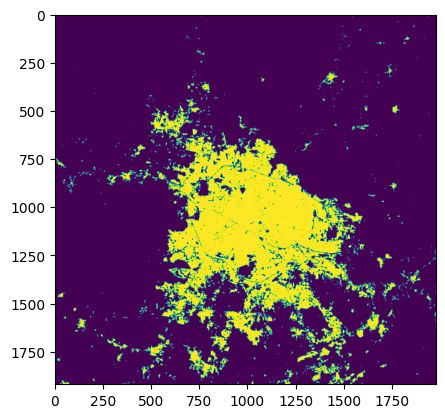

In [15]:
array_target = tile_to_numpy(built_2015_hr_reprojected, segment_list[0], bands_B)
print("New label array", array_target.shape)
for segment in segment_list[1:]:
  target_segment = tile_to_numpy(built_2015_hr_reprojected, segment, bands_B)
  print("Label segment", target_segment.shape)
  array_target = np.concatenate((array_target, target_segment), 1)
print("Full new label array", array_target.shape)

# Scale the data to [0, 255] to show as an RGB image.
rgb_img_new = (array_target).astype('uint8')
plt.imshow(rgb_img_new[:,:,0])
plt.show()

In [16]:
# Save the arrays as .npy files
np.save('/content/drive/MyDrive/Colab Data/array_full_feature.npy', array_feature)
np.save('/content/drive/MyDrive/Colab Data/array_full_target.npy', array_target)

In [17]:
#array_full_t = np.transpose(array_small_feature, (2, 0, 1))
#array_labels_t = np.transpose(array_small_labels, (2, 0, 1))

array_full_t = np.transpose(array_feature, (2, 0, 1))
array_labels_t = np.transpose(array_target, (2, 0, 1))


print(array_full_t.shape)
print(array_labels_t.shape)
x_features = convert.array_to_table(array_full_t)
y_labels = convert.array_to_table(array_labels_t)
#featuresHyderabad = changeDimension(featuresHyderabad)
nBands = x_features.shape[1]
#labelBangalore = (labelBangalore == 1).astype(int)

print(x_features.shape)
print(x_features)
print(y_labels.shape)
print(y_labels)

unique_values, occurrence_count = np.unique(y_labels, return_counts=True)
print(unique_values)
print(occurrence_count)

(6, 1920, 1980)
(1, 1920, 1980)
(3801600, 6)
[[ 8095  8507  8419 11984 11514  9731]
 [ 8218  8651  8686 13020 12499 10187]
 [ 8253  8735  8730 13627 12826 10384]
 ...
 [ 8325  8922  9221 13625 14225 11741]
 [ 8249  8871  9016 13664 14173 11835]
 [ 8220  8754  8927 13744 13767 11219]]
(3801600, 1)
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
[  0 255]
[3135229  666371]


In [18]:
from sklearn.model_selection import train_test_split

# Normalise the data
y_labels = y_labels / 255
x_features = x_features / 32768

xTrain, xTest, yTrain, yTest = train_test_split(x_features, y_labels, test_size=0.4, random_state=42)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

print(xTrain)
print(yTrain)

# Reshape the data
xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
xTest = xTest.reshape((xTest.shape[0], 1, xTest.shape[1]))

print(xTrain.shape, xTest.shape)

(2280960, 6)
(2280960, 1)
(1520640, 6)
(1520640, 1)
[[0.2538147  0.27026367 0.27276611 0.38259888 0.39038086 0.32189941]
 [0.28060913 0.30151367 0.32055664 0.41781616 0.484375   0.41040039]
 [0.33215332 0.36431885 0.38150024 0.38812256 0.38626099 0.36767578]
 ...
 [0.28222656 0.30258179 0.33065796 0.42617798 0.54153442 0.45288086]
 [0.28851318 0.3135376  0.33248901 0.46759033 0.57754517 0.46734619]
 [0.27990723 0.30047607 0.31744385 0.4336853  0.48321533 0.42630005]]
[[0.]
 [0.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]
(2280960, 1, 6) (1520640, 1, 6)


Train neural network

In [19]:
from tensorflow import keras

# Define the parameters of the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(14, activation='relu'),
    keras.layers.Dense(2, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Run the model
model.fit(xTrain, yTrain, epochs=5)

Epoch 1/5
71280/71280 [==============================] - 130s 2ms/step - loss: 0.1810 - accuracy: 0.9342
Epoch 2/5
71280/71280 [==============================] - 128s 2ms/step - loss: 0.1531 - accuracy: 0.9438
Epoch 3/5
71280/71280 [==============================] - 129s 2ms/step - loss: 0.1510 - accuracy: 0.9441
Epoch 4/5
71280/71280 [==============================] - 127s 2ms/step - loss: 0.1502 - accuracy: 0.9444
Epoch 5/5
71280/71280 [==============================] - 130s 2ms/step - loss: 0.1498 - accuracy: 0.9445


In [20]:
model.save('/content/drive/MyDrive/Colab Data/model_full_data_test.tensorflow')

In [21]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Predict for test data
yTestPredicted = model.predict(xTest)
yTestPredicted = yTestPredicted[:,1]

# Calculate and display the error metrics
yTestPredicted = (yTestPredicted>0.5).astype(int)
cMatrix = confusion_matrix(yTest, yTestPredicted)
pScore = precision_score(yTest, yTestPredicted)
rScore = recall_score(yTest, yTestPredicted)

print("Confusion matrix:\n", cMatrix)
print("\nprecision: %.3f, recall: %.3f" % (pScore, rScore))

47520/47520 [==============================] - 71s 1ms/step
Confusion matrix:
 [[1217704   36503]
 [  47118  219315]]

precision: 0.857, recall: 0.823


118800/118800 [==============================] - 188s 2ms/step
[[9.9999994e-01 2.2380420e-18]
 [9.9999994e-01 2.2380761e-18]
 [9.9999994e-01 2.2381359e-18]
 ...
 [9.9999994e-01 2.2381274e-18]
 [9.9999994e-01 2.2381274e-18]
 [9.9999994e-01 2.2381104e-18]]


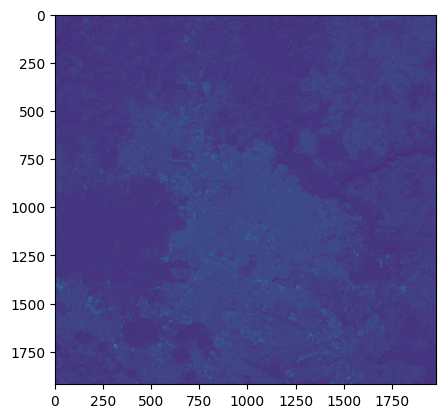

In [22]:
x_features_n = x_features / 32768
x_features_n = x_features_n.reshape((x_features_n.shape[0], 1, x_features_n.shape[1]))

predicted = model.predict(x_features_n)
print(predicted)
predicted = predicted[:,1] * 255


#Export raster
prediction = np.reshape(predicted, (array_target.shape[0], array_target.shape[1]))
#B_img_pred = (prediction).astype('uint8')
B_img_pred = (prediction).astype('float')
plt.imshow(B_img_pred[:,:])
plt.show()